# 第13章 平稳时间序列

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

data = pd.read_stata('../2_Data/Data-2e/gdp_china.dta')
data.set_index('year', inplace=True)
data['lny'] = np.log(data['y'])
data['dlny']  = data['lny'].diff().dropna()
data['dy'] = (data['y'] - data['y'].shift(1))/data['y'].shift(1)


class Dataset:
    def __init__(self, data):
        self.original = data
        self.dif = self.dif_y()
        self.lny = self.ln_y()
        self.dlny = self.dln_y()
        self.dy = self.d_y()



## 13.1 时间序列的自相关

自相关图（ACF）是描述时间序列自相关性的图形。它显示了时间序列的相关性随时间的变化情况。

ACF的计算方法：

1. 计算时间序列的差分值（即滞后1阶）
2. 计算差分值的自相关函数

ACF的计算公式：

$$
\rho_k = \frac{\sum_{t=1}^{T-k}(y_t-\bar{y})(y_{t+k}-\bar{y})}{\sqrt{\sum_{t=1}^{T}(y_t-\bar{y})^2\sum_{t=1}^{T}(y_{t+k}-\bar{y})^2}}
$$

其中，$\rho_k$表示滞后k阶的自相关系数，$T$表示时间序列的长度，$y_t$表示时间序列的第t个观测值，$\bar{y}$表示时间序列的均值。

<Axes: xlabel='year', ylabel='y'>

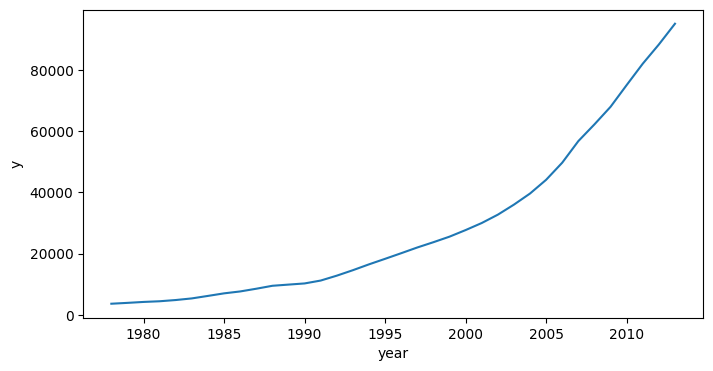

In [2]:
# 时间序列的趋势图
fig = plt.figure(figsize=(8,4))
sns.lineplot(x='year', y='y', data=data)

<Axes: xlabel='year', ylabel='lny'>

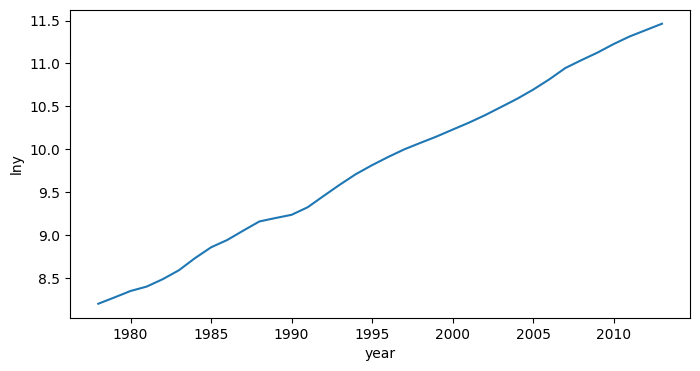

In [3]:
# 对数时间序列的趋势图
fig = plt.figure(figsize=(8,4))
sns.lineplot(x='year', y='lny', data=data)

<Axes: xlabel='year', ylabel='dlny'>

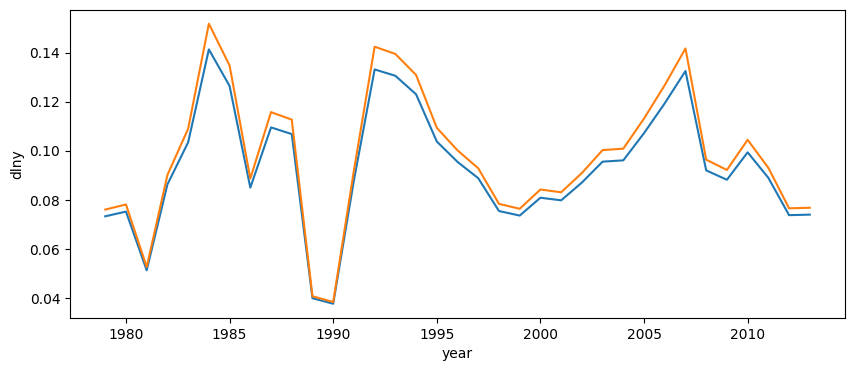

In [4]:
# 对比
fig = plt.figure(figsize=(10,4))
sns.lineplot(x='year', y='dlny', data=data)
sns.lineplot(x='year', y='dy', data=data)

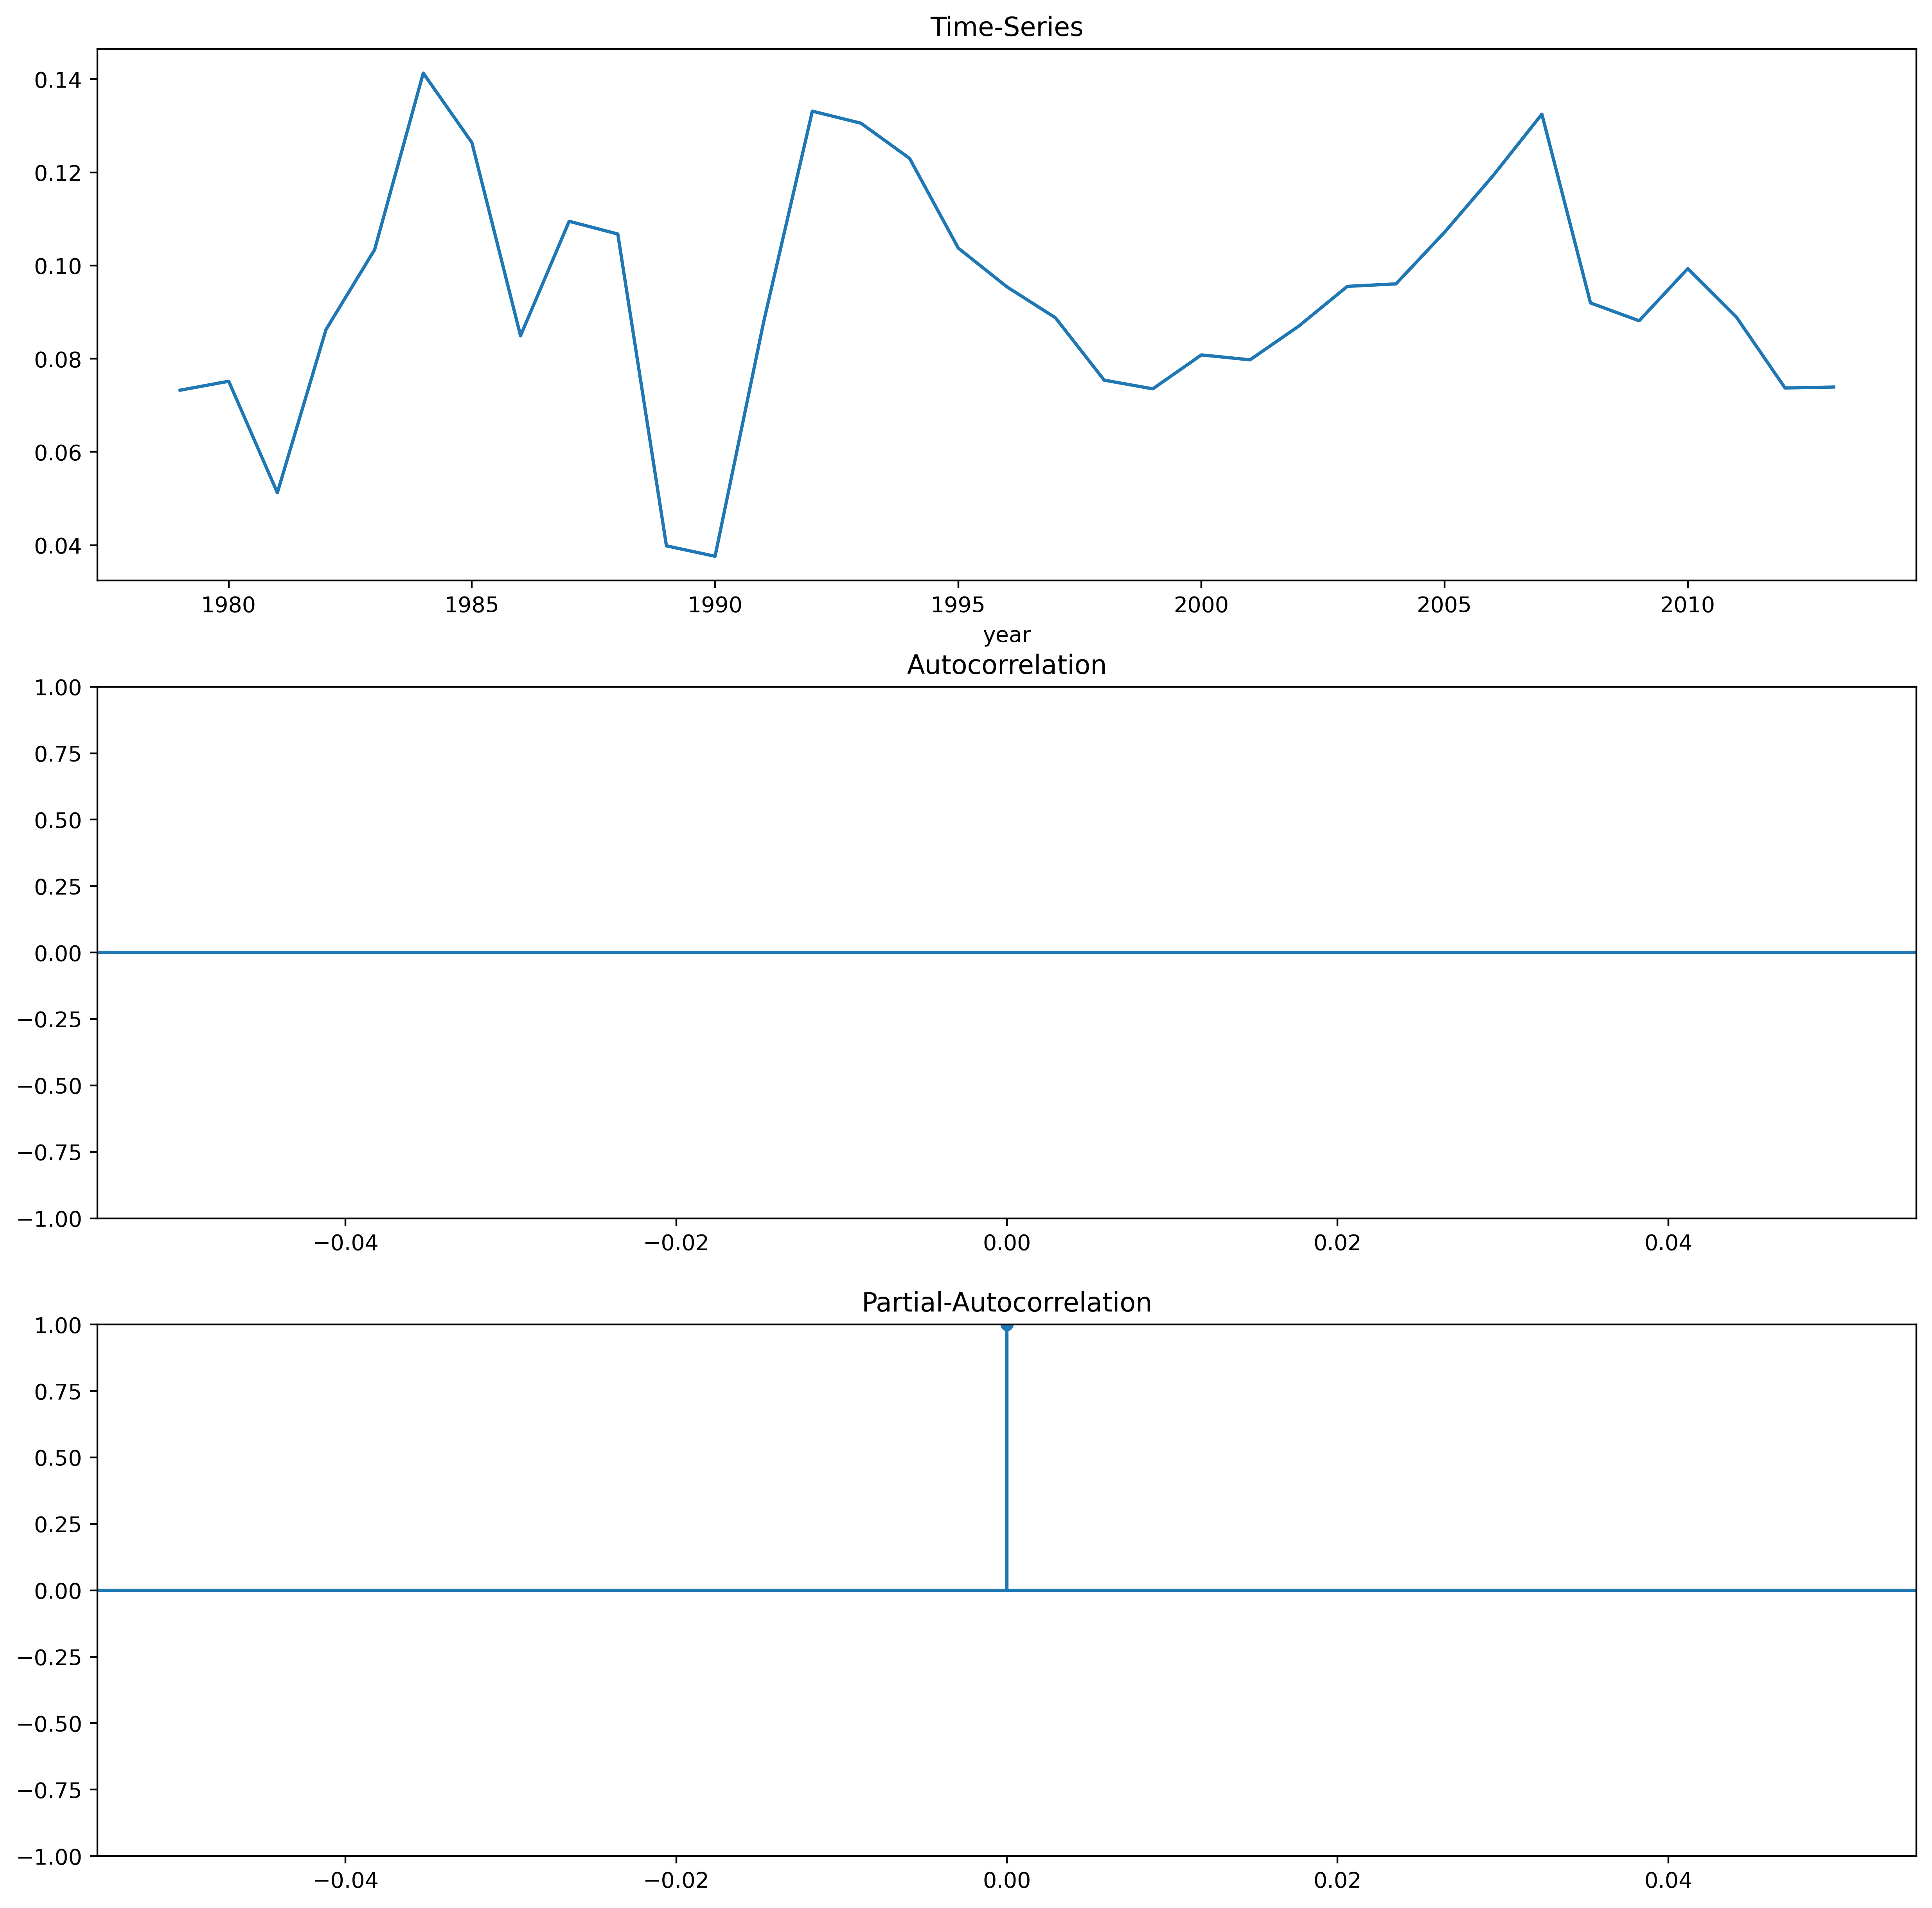

,Lags,ACF,PACF,Q,Prob(Q)
0,1,NaN,NaN,NaN,NaN
1,2,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN
3,4,NaN,NaN,NaN,NaN
4,5,NaN,NaN,NaN,NaN
5,6,NaN,NaN,NaN,NaN
6,7,NaN,NaN,NaN,NaN
7,8,NaN,NaN,NaN,NaN
8,9,NaN,NaN,NaN,NaN
9,10,NaN,NaN,NaN,NaN


In [5]:
from cq import acfgram

ac = acfgram(data['dlny'],lags=15)
ac


## 13.2 一阶自回归



In [6]:
# 使用OLS回归
data2012 = data[data.index<2013].dropna()
mod_ols = sm.OLS(endog=data2012['dlny'], 
             exog=sm.add_constant(data2012['dlny'].shift(1)),
             missing='drop') # 缺失值直接drop
res_ols = mod_ols.fit(cov_type='HC1', use_t=True)
print(res_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                   dlny   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     12.99
Date:                Sun, 05 May 2024   Prob (F-statistic):            0.00108
Time:                        02:39:19   Log-Likelihood:                 80.961
No. Observations:                  33   AIC:                            -157.9
Df Residuals:                      31   BIC:                            -154.9
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0438      0.014      3.039      0.0

In [7]:
# 使用MLE
from statsmodels.tsa.ar_model import AutoReg
mod_mle = AutoReg(data2012['dlny'], lags=1)
res_mle = mod_mle.fit(cov_type='HC1',use_t=True)
print(res_mle.summary())

                            AutoReg Model Results                             
Dep. Variable:                   dlny   No. Observations:                   34
Model:                     AutoReg(1)   Log Likelihood                  80.961
Method:               Conditional MLE   S.D. of innovations              0.021
Date:                Sun, 05 May 2024   AIC                           -155.922
Time:                        02:39:19   BIC                           -151.433
Sample:                             1   HQIC                          -154.412
                                   34                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0438      0.014      3.039      0.005       0.014       0.073
dlny.L1        0.5363      0.149      3.604      0.001       0.233       0.840
                                    Roots           

e:\Eco-stats\eco-stats\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [8]:
from math import exp
# 预测值
a = res_ols.predict([1,data.loc[2013,'dlny']])
# OLS模型回归后的预测：
## - 参数是对应的 const + 其他自变量的值
b = res_mle.predict(len(data['lny']),len(data['lny']))
# AutoReg模型回归后的预测：
## - 参数是start, end

resid = exp(a + data.loc[2012,'lny']) - data.loc[2013,'y']
resid

e:\Eco-stats\eco-stats\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
e:\Eco-stats\eco-stats\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
e:\Eco-stats\eco-stats\.venv\lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\NINGMEI\AppData\Local\Temp\ipykernel_210248\669965748.py:10: DeprecationWarning: Conversion of an array with ndim > 0 t

906.3107431212557

## 13.3 高阶自回归



In [10]:
from cq import estimate_p

data = data[data.index< 2013]
df = estimate_p(data, 'dlny', 3)
df

index    nobs         p-value             AIC             BIC
dlny_l1  33.0        0.000313  -157.9223[min]  -154.9293[min]
dlny_l2  32.0         0.00336     -157.398728      -153.00152
dlny_l3  31.0  0.90479[>0.05]     -153.816216     -148.080267


e:\Eco-stats\eco-stats\Econometrics_CQ\1_Code\cq.py:214: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return res.params.index[-1], res.nobs, res.pvalues[-1], res.aic, res.bic
e:\Eco-stats\eco-stats\Econometrics_CQ\1_Code\cq.py:214: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return res.params.index[-1], res.nobs, res.pvalues[-1], res.aic, res.bic
e:\Eco-stats\eco-stats\Econometrics_CQ\1_Code\cq.py:214: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use

## 13.4 自回归分布滞后模型




## 13.5 误差修正模型



## 13.6 移动平均与ARMA模型



## 13.7 脉冲响应函数



## 13.8 向量自回归过程



## 13.9 VAR的脉冲响应函数



## 13.10 格兰杰因果检验



## 13.11 VAR的Stata命令及实例



## 13.12 时间趋势项



## 13.13 季节调整



## 13.14 日期数据的导入